In [1]:
import arviz as az
import bambi as bmb
import xarray as xr  # to see the version
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Turn off logging for NUTS sampler for PyMCMC
import logging

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

In [2]:
rng = np.random.default_rng(seed=42)

*Gries, chapter 5.5.4 (pp. 333-336)*

Let us illustrate the use of binary logistic **mixed effects** regression with an exercise on teenagers' verb spelling errors (dataset 'spelling').

In [3]:
spelling = pd.read_csv(
    "../../datasets/spelling/spelling.tsv", sep="\t", encoding="Windows-1252"
)
spelling

,subject_ID,lemma,gender,age,education,grade,error
0,325,aanbidden,male,17,general,Gr3,0
1,563,aanbidden,female,18,technical,Gr3,0
2,742,aanbieden,male,18,vocational,Gr3,0
3,899,aanbieden,male,17,vocational,Gr3,0
4,625,aanbieden,female,16,general,Gr2,0
...,...,...,...,...,...,...,...
5820,website88,worden,female,17,general,Gr3,0
5821,website88,worden,female,17,general,Gr3,0
5822,website88,worden,female,17,general,Gr3,0
5823,325,zenden,male,17,general,Gr3,0


##### Question: Why does the assumption of data independence NOT hold for this dataset? 
> Where are there repeated measurements in the data? Take a look at both 'subject_ID' and 'lemma'. Using the `is_unique` property of the columns you should easily see that they are not unique. Because there are unbalanced numbers of test-takers, the results would be distorted (it would be like an individual voting many times in an election)

In this case, we need to deal with the repeated measurements. The approach is called many different things:
- 'controlling for' the repeated individual results
- 'stratifying' the data
- 'hierarchical' models
- 'mixed effects' models
- 'random effects' models
- ...etc.

## Binary logistic mixed effects regression

Here we need a binary logistic **mixed effects model**. You will notice that the syntax looks almost identical to what you are saw for regular binary logistic models from `statsmodels`. That makes sense, because what we will be fitting now, is just a special ('mixed effects') variant of that same model, that is adapted in a way so that it can deal with repeated measurements in the data.

> For Python specifically, as of October 12, 2024, the libraries for modelling and interpreting this kind of problem are easier to understand and better-featured on the Bayesian side. The `statsmodels` version of this type of model also uses Bayesian estimation for the parameters, but presents the results according to the `statsmodels` outlook. The `bambi` version is also Bayesian, but has (in our opinion) a cleaner API and better diagnostics.

## Bayesian vs Frequentist Models

There is no (statistically) **better or worse** approach, in a vacuum, to modelling this kind of data. You are about to learn the Bayesian style, but the difference is only in the way the estimates are calculated but (much more importantly) the way they are interpreted. As we said before, both styles work, and both have many fanatical devotees.


As before, we want to fit a logistic regression, with a binary outcome. The `bambi` library uses the R style formula language, so that should be familiar. You will see a few things that are new.
- The specification `(1|lemma)` and `(1|subject_ID)` creates two *random intercept groups*. This allows the *intercept* to vary between individual students (some students are better than others at spelling) and individual lemmas (some words are harder to spell)
- The family `bernoulli` refers to (yet another) distribution, and is the correct choice for logistic models with *binary* outcomes

The interpretation of this part of the output falls outside the scope of this course. What does fall within the scope of the course, is: **knowing that you should always test your data for data independence, and subsequently knowing when to switch to a mixed effects rather than a regular regression model or not.**

First we specify the model (by formula), and then build it (but don't fit it yet).

In [4]:
model_hierarchical = bmb.Model(
    "error ~ 0 + gender + education + grade + (1|lemma) + (1|subject_ID) ",
    spelling,
    family="bernoulli",
)
model_hierarchical.build()

As before, we see that `bambi` has automatically chosen sensible priors for us. Recall that these are all categorical predictors, so what is being estimated is the mean effect of each predictor level.

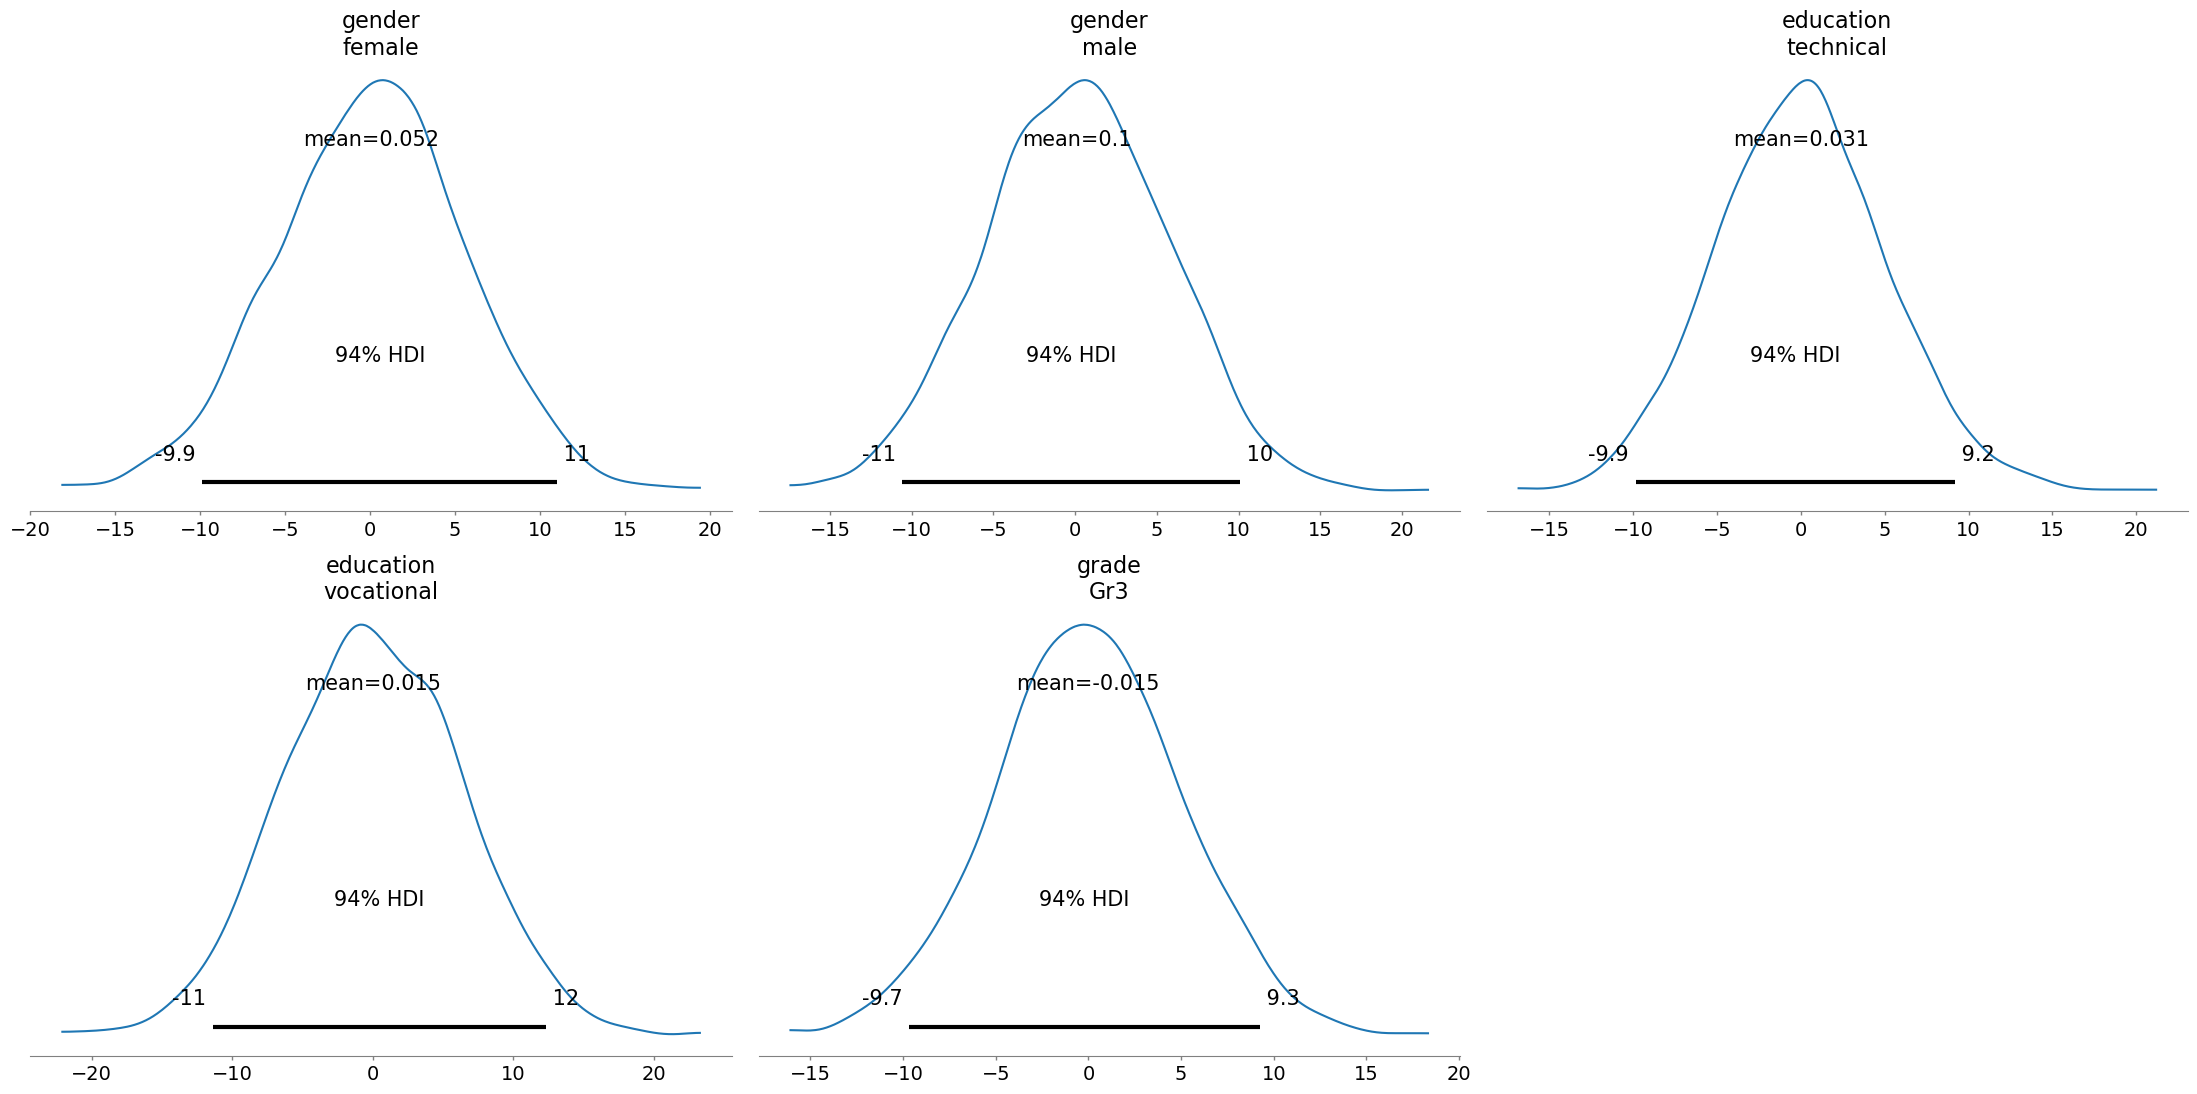

In [5]:
model_hierarchical.plot_priors(var_names=["gender", "education", "grade"])
plt.tight_layout()
plt.show()

In [6]:
idata_hierarchical = model_hierarchical.fit(
    target_accept=0.9,
    random_seed=rng,
    progressbar=False,
)
az.summary(idata_hierarchical, var_names=["gender", "education", "grade"])

Modeling the probability that error==1


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gender[female],-0.934,0.250,-1.403,-0.474,0.010,0.007,570.0,1112.0,1.01
gender[male],-0.540,0.259,-1.047,-0.085,0.010,0.007,612.0,1360.0,1.00
education[technical],0.844,0.147,0.575,1.134,0.004,0.003,1091.0,1657.0,1.00
education[vocational],1.248,0.158,0.958,1.559,0.004,0.003,1268.0,2237.0,1.00
grade[Gr3],-0.238,0.098,-0.420,-0.048,0.002,0.002,1808.0,2146.0,1.00


After fitting, our estimates have narrowed a lot!

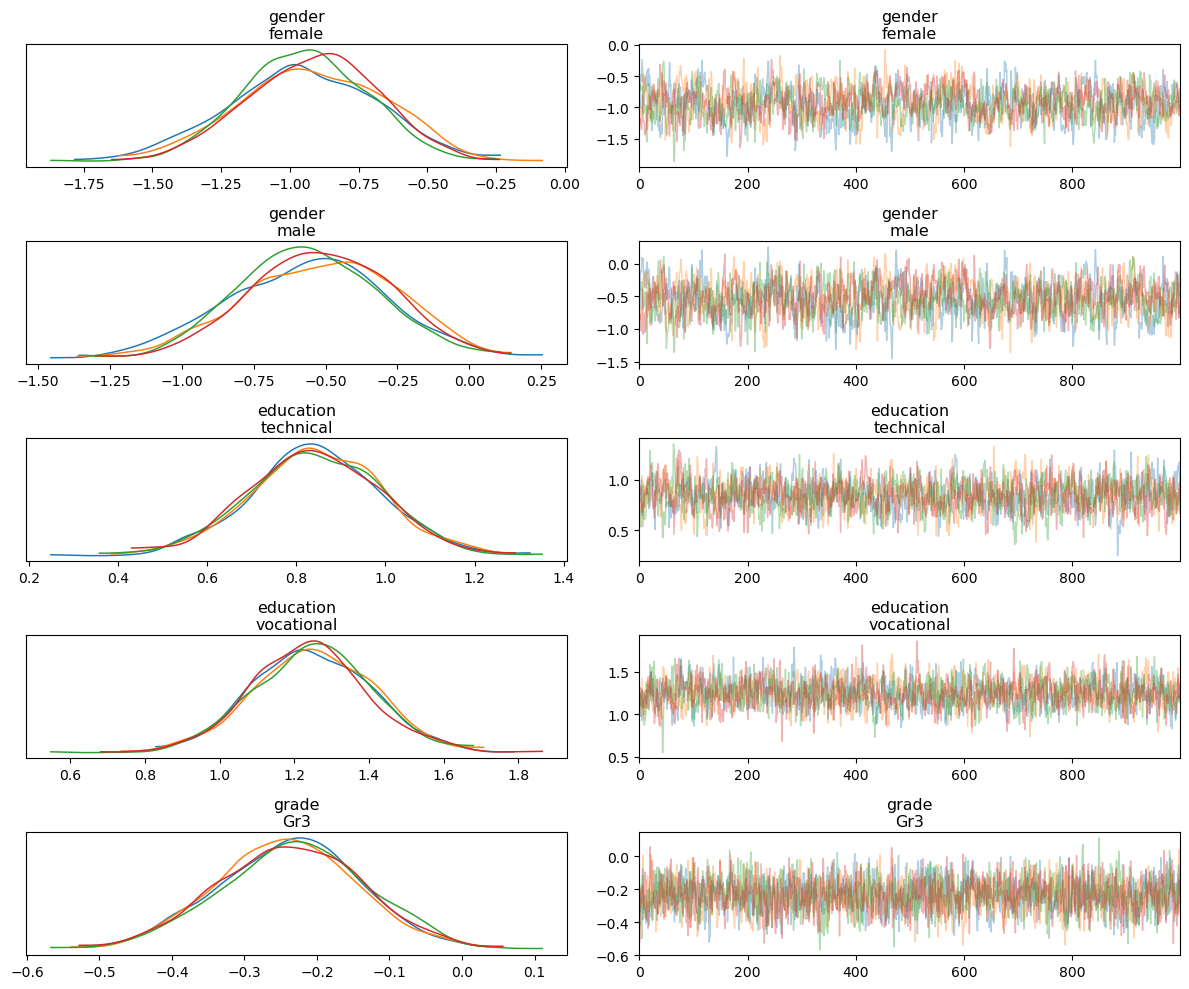

In [7]:
az.plot_trace(
    idata_hierarchical, compact=False, var_names=["gender", "education", "grade"]
)
plt.tight_layout()
plt.show()

## Model Interpretation

## Predictions and Effects

`bambi` provides easy to use tools to plot predictions and effects. When we plot *predictions* it will mariginalize over the variables we give it and (for this kind of model) automatically convert the parameters into probabilities. First let's look at gender vs education

Default computed for conditional variable: grade, gender
Default computed for unspecified variable: education, lemma, subject_ID


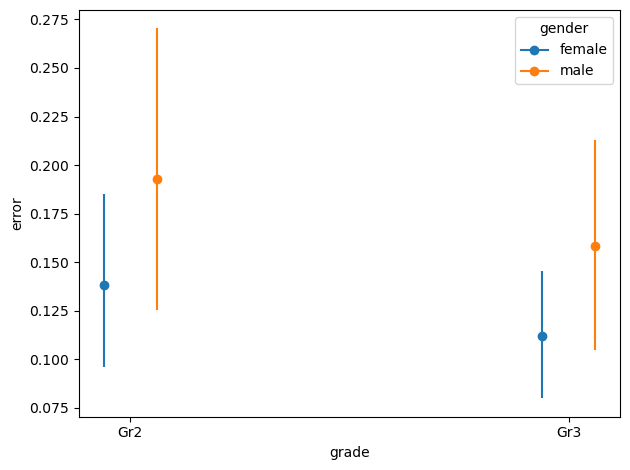

In [8]:
bmb.interpret.plot_predictions(
    model_hierarchical,
    idata_hierarchical,
    conditional=["grade", "gender"],
)
plt.tight_layout()
plt.show()

> EXERCISE: How should we interpret this plot?

> EXERCISE: Can you add 'grade' to this plot? What happens? What about swapping the order, maybe grade first?

### Effects

We can also plot treatment effects using the `plot_comparisons()` method. Note carefully that this shows us a *change* not an absolute probability. Here wer specify a `contrast` (the treatment effect we want to measure), and we can then *condition* on other predictors.

Default computed for contrast variable: gender
Default computed for conditional variable: education, grade
Default computed for unspecified variable: lemma, subject_ID


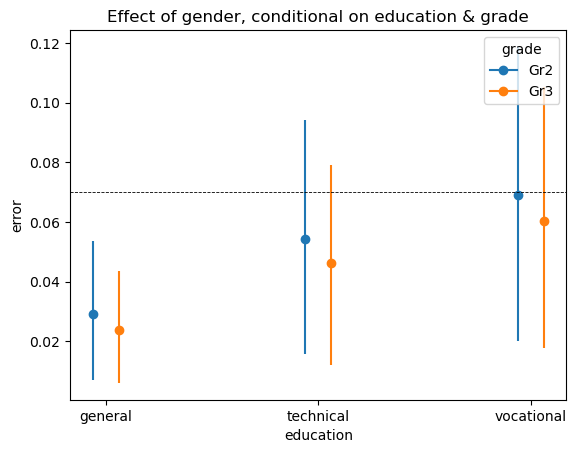

In [11]:
fig, _ = bmb.interpret.plot_comparisons(
    model=model_hierarchical,
    idata=idata_hierarchical,
    contrast="gender",
    conditional=["education", "grade"],
)
fig.get_axes()[0].axhline(0.07, linestyle="--", linewidth=0.6, color="black")
plt.title("Effect of gender, conditional on education & grade")
plt.show()

How should we interpret this? Well, it says, for example, that in vocational education, in Grade 2, applying the gender treatment (from baseline female to male) increases the probability of spelling errors by about 7% *on average*, but there is a lot of uncertainty in the estimate. Let's check that with a raw predictions table....

In [ ]:
preds = bmb.interpret.predictions(
    model_hierarchical,
    idata_hierarchical,
    ["gender", "education", "grade"],
)
preds

Default computed for conditional variable: gender, education, grade
Default computed for unspecified variable: lemma, subject_ID


,gender,education,grade,lemma,subject_ID,estimate,lower_3.0%,upper_97.0%
0,female,general,Gr2,vinden,563,0.065245,0.037472,0.092573
1,female,general,Gr3,vinden,563,0.052045,0.031167,0.073420
2,female,technical,Gr2,vinden,563,0.138238,0.095790,0.185044
3,female,technical,Gr3,vinden,563,0.112047,0.079914,0.145335
4,female,vocational,Gr2,vinden,563,0.194393,0.122276,0.267670
5,female,vocational,Gr3,vinden,563,0.159868,0.103648,0.221241
6,male,general,Gr2,vinden,563,0.094331,0.049261,0.138522
7,male,general,Gr3,vinden,563,0.075718,0.042297,0.111203
8,male,technical,Gr2,vinden,563,0.192712,0.125269,0.270349
9,male,technical,Gr3,vinden,563,0.158184,0.104752,0.213126


In [ ]:
subset = preds[(preds.education == "vocational") & (preds.grade == "Gr2")]
subset

,gender,education,grade,lemma,subject_ID,estimate,lower_3.0%,upper_97.0%
4,female,vocational,Gr2,vinden,563,0.194393,0.122276,0.26767
10,male,vocational,Gr2,vinden,563,0.263581,0.166785,0.37113


In [ ]:
subset.iloc[1, 5:] - subset.iloc[0, 5:]

estimate       0.069188
lower_3.0%     0.044509
upper_97.0%     0.10346
dtype: object

> REMEMBER: In Bayesian analysis, the estimate is the *entire distribution*. When you report predictions and/or effects you should always report some kind of uncertainty. The ideal way for Bayesian models is to plot the full posterior. If you can't, you can *summarize* the estimate by using eg the bounds of the 94% HDI.

```
Version History

Current: v1.0.0

17/11/24: 1.0.0: first draft, BN
```